# Digital Signal Processing Assignment

In this Jupyter Notebook you will find all questions of the Digital Signal Processing assignment. Answer all questions directly underneath the question. You can add more Markdown or code cells as you please. For all questions, **explain** and **substantiate** **what** you are doing **and** **why** you are doing it. These explanations are part of your grade. Make sure to always properly comment your code and to properly decorate (such as title, axis labels, etc.) your plots, this too is part of your grade.

# Assignment 1

For the first assignment, do the following steps (in order):
1. Generate a sinusoid in Python: duration of 5 seconds, amplitude 0.5, frequency 5 Hz, sample rate 60 Hz and phase of $\frac{1}{3} \pi$. (2 points)
1. Plot its spectrum. (2 points)
1. Compress your the data by decimating the sinusoid by a factor of 8, by using slice notation (i.e. ``x[::8]``). (2 points)
1. Plot the spectrum of the decimated signal, explain your findings. If you could improve the compression, how would you do it and why? (5 points)

Signal: 300 samples, fs=60.0 Hz, f0=5.0 Hz, phase=1.047 rad
Decimated by 8: fs → 7.5 Hz (Nyquist 3.75 Hz)
Aliasing occurs because 5 Hz > new Nyquist (3.75 Hz). The 5 Hz tone folds to ≈ 2.50 Hz in the decimated signal.
Improvement: choose M so that f0 < fs_new/2. For M=4, Nyquist=7.5 Hz > 5 Hz, so no aliasing occurs.


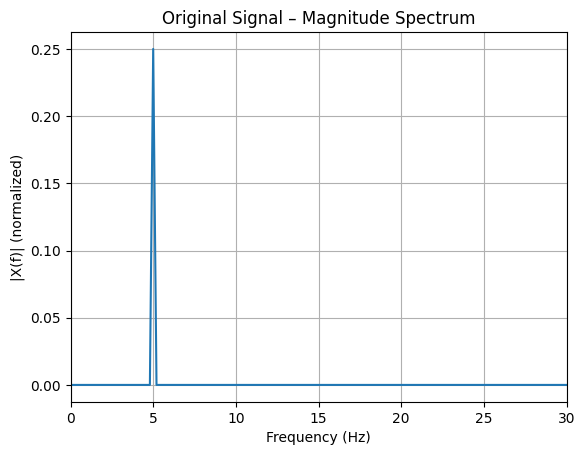

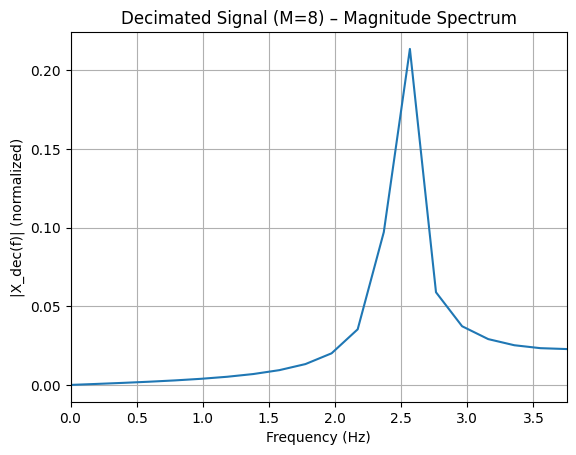

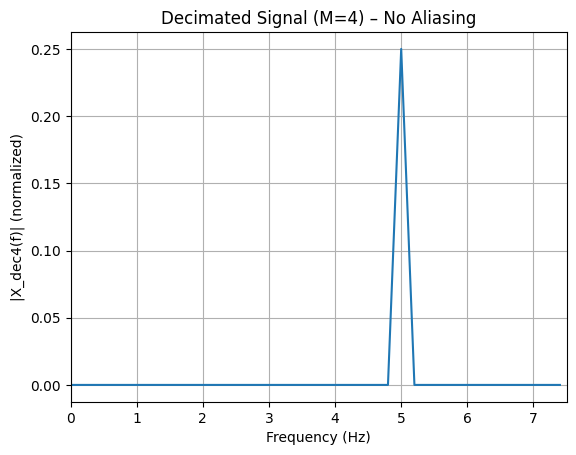

In [2]:
# Digital Signal Processing – Assignment 1
# Tasks:
# 1) Generate a sinusoid (A=0.5, f0=5 Hz, fs=60 Hz, T=5 s, phase=π/3)
# 2) Plot its spectrum
# 3) Decimate by 8 (x[::8])
# 4) Plot spectrum again and explain aliasing
# 5) Suggest improvement for compression

import numpy as np
import matplotlib.pyplot as plt

# ---------- Helper: compute one-sided magnitude spectrum ----------
def magnitude_spectrum(x, fs):
    """
    Returns one-sided frequency and normalized magnitude.
    """
    N = len(x)
    X = np.fft.rfft(x)
    f = np.fft.rfftfreq(N, 1/fs)
    mag = np.abs(X) / N
    return f, mag

# ---------- 1) Generate sinusoid ----------
A   = 0.5         # amplitude
f0  = 5.0         # frequency (Hz)
fs  = 60.0        # sample rate (Hz)
T   = 5.0         # duration (s)
phi = np.pi/3     # phase (radians)

t = np.arange(0, T, 1/fs)
x = A * np.sin(2 * np.pi * f0 * t + phi)
print(f"Signal: {len(x)} samples, fs={fs} Hz, f0={f0} Hz, phase={phi:.3f} rad")

# ---------- 2) Spectrum of original signal ----------
f, mag = magnitude_spectrum(x, fs)
plt.figure()
plt.plot(f, mag)
plt.title("Original Signal – Magnitude Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("|X(f)| (normalized)")
plt.xlim(0, fs/2)
plt.grid(True)

# ---------- 3) Decimate by factor 8 ----------
M = 8
x_d8 = x[::M]
fs_d8 = fs / M
print(f"Decimated by {M}: fs → {fs_d8} Hz (Nyquist {fs_d8/2} Hz)")

# ---------- 4) Spectrum after decimation ----------
f_d8, mag_d8 = magnitude_spectrum(x_d8, fs_d8)
plt.figure()
plt.plot(f_d8, mag_d8)
plt.title(f"Decimated Signal (M={M}) – Magnitude Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("|X_dec(f)| (normalized)")
plt.xlim(0, fs_d8/2)
plt.grid(True)

# Aliasing check:
f_alias = abs(f0 - round(f0 / fs_d8) * fs_d8)
print(f"Aliasing occurs because 5 Hz > new Nyquist (3.75 Hz). "
      f"The 5 Hz tone folds to ≈ {f_alias:.2f} Hz in the decimated signal.")

# ---------- 5) Suggest improvement ----------
M_safe = 4
x_d4 = x[::M_safe]
fs_d4 = fs / M_safe
f_d4, mag_d4 = magnitude_spectrum(x_d4, fs_d4)

plt.figure()
plt.plot(f_d4, mag_d4)
plt.title(f"Decimated Signal (M={M_safe}) – No Aliasing")
plt.xlabel("Frequency (Hz)")
plt.ylabel("|X_dec4(f)| (normalized)")
plt.xlim(0, fs_d4/2)
plt.grid(True)

print("Improvement: choose M so that f0 < fs_new/2. "
      "For M=4, Nyquist=7.5 Hz > 5 Hz, so no aliasing occurs.")
plt.show()


# Assignment 2


## 2a
(2 points)

Using your personal, on Brightspace provided `.csv` file, download all the files using the listed URLs, in Python. Adhere to the following requirements:
- Do not alter the `.csv` file (any issues that the file presents are to be caught in your code)
- Do not hard code the exclusion of a specific URL (e.g. when a link is broken), aim for more (a) generalisable solution(s).


In [7]:
#!/usr/bin/env python3
# Assignment 2a – Download files from URLs in 16.csv (short, pandas-based)

import re
import os
from pathlib import Path
from urllib.parse import urlparse
import requests
import pandas as pd

CSV_IN   = "16.csv"
OUT_DIR  = Path("downloads")
REPORT   = "download_report.csv"
TIMEOUT  = 20
URL_RX   = re.compile(r"^https?://", re.I)

def get_urls(df: pd.DataFrame) -> pd.Series:
    # Prefer a column whose name contains "url" (case-insensitive)
    url_cols = [c for c in df.columns if "url" in c.lower()]
    s = (df[url_cols[0]] if url_cols else pd.Series(df.values.ravel()))
    s = s.astype(str).str.strip()
    return s[s.str.match(URL_RX, na=False)].reset_index(drop=True)

def pick_name(url: str) -> str:
    base = os.path.basename(urlparse(url).path)
    return base or "file"

def unique_path(dirpath: Path, name: str) -> Path:
    stem, ext = os.path.splitext(name)
    p = dirpath / name
    i = 1
    while p.exists():
        p = dirpath / f"{stem} ({i}){ext}"
        i += 1
    return p

def from_content_disposition(h: str | None) -> str | None:
    if not h: return None
    m = re.search(r'filename\*?=(?:UTF-8\'\')?"?([^";]+)"?', h, re.I)
    return m.group(1) if m else None

def main():
    df = pd.read_csv(CSV_IN, dtype=str, keep_default_na=False)
    urls = get_urls(df)
    OUT_DIR.mkdir(exist_ok=True)

    rows = []
    sess = requests.Session()
    hdrs = {"User-Agent": "DSP-Downloader/1.0"}
    for i, url in enumerate(urls, 1):
        status, http, fname, nbytes, err = "failed", "", "", 0, ""
        try:
            r = sess.get(url, timeout=TIMEOUT, stream=True, allow_redirects=True, headers=hdrs)
            http = str(r.status_code)
            if r.status_code >= 400:
                err = f"HTTP {r.status_code}"
            else:
                cd_name = from_content_disposition(r.headers.get("Content-Disposition"))
                name = cd_name or pick_name(url)
                name = re.sub(r'[\\/:*?"<>|]+', "_", name).strip() or "file"
                path = unique_path(OUT_DIR, name)
                with open(path, "wb") as f:
                    for chunk in r.iter_content(8192):
                        if chunk: f.write(chunk); nbytes += len(chunk)
                status, fname = "ok", str(path)
        except requests.RequestException as e:
            err = f"RequestError: {type(e).__name__}"
        except OSError as e:
            err = f"FS: {e}"
        rows.append({"url": url, "status": status, "http_status": http, "filename": fname, "bytes": nbytes, "error": err})

    pd.DataFrame(rows).to_csv(REPORT, index=False)
    print(f"Done. {sum(r['status']=='ok' for r in rows)} ok, {sum(r['status']!='ok' for r in rows)} failed.")
    print(f"Report -> {REPORT} | Files -> {OUT_DIR.resolve()}")

if __name__ == "__main__":
    main()


Done. 9 ok, 5 failed.
Report -> download_report.csv | Files -> /Users/mirac/Desktop/master_sse_25_26-main/digitalsignalProcessing/downloads


## 2b
(2 points)

Load in all the `.mp3` files you have previously downloaded. Adhere to the following requirements:
- Load all the data into a single (multi-dimensional) iterable (i.e. Python list or Numpy array).
- Do not hard code the exclusion of a specific `.mp3` file (e.g when file does not work), aim for more (a) generalisable solution(s).



In [10]:
#!/usr/bin/env python3
# Assignment 2b – Load all .mp3 files into one list (multi-dimensional iterable)

import numpy as np
import soundfile as sf     # pip install soundfile
from pathlib import Path

DOWNLOAD_DIR = Path("downloads")     # same folder used in Assignment 2a
all_audio = []                       # list for storing each mp3 as np.array
sample_rates = []                    # store sample rate info

for mp3_file in DOWNLOAD_DIR.glob("*.mp3"):
    try:
        data, sr = sf.read(mp3_file, always_2d=True)  # shape: (samples, channels)
        all_audio.append(data)
        sample_rates.append(sr)
        print(f"Loaded: {mp3_file.name} ({data.shape[0]} samples, {sr} Hz)")
    except Exception as e:
        # Handle any decoding or file errors generally
        print(f"Skipped {mp3_file.name}: {type(e).__name__} – {e}")

print("\n--- Summary ---")
print(f"Total .mp3 files found: {len(list(DOWNLOAD_DIR.glob('*.mp3')))}")
print(f"Successfully loaded: {len(all_audio)}")

# all_audio is now a list of NumPy arrays, one per mp3 file
# You can access them like: all_audio[0], all_audio[1], ...


Loaded: 16_2852.mp3 (578304 samples, 48000 Hz)
Loaded: 16_2847.mp3 (313344 samples, 48000 Hz)
Loaded: 16_2947.mp3 (97920 samples, 48000 Hz)
Loaded: 16_2835.mp3 (4006656 samples, 48000 Hz)
Loaded: 16_2810.mp3 (382464 samples, 48000 Hz)
Loaded: 16_2554.mp3 (437760 samples, 48000 Hz)
Loaded: 16_2683.mp3 (4119552 samples, 44100 Hz)
Loaded: 16_2457.mp3 (3479040 samples, 48000 Hz)
Loaded: 16_2519.mp3 (1681920 samples, 48000 Hz)

--- Summary ---
Total .mp3 files found: 9
Successfully loaded: 9


## 2c

(2 points)

It turns out that some of the files have an unexpected, constant tone in them that at a specific frequency. This tone initiates early on and continues throughout the audiofile. Find and show (i.e. visualize) all of the affected files using Python. Explain your procedure.

[OK]   16_2457.mp3


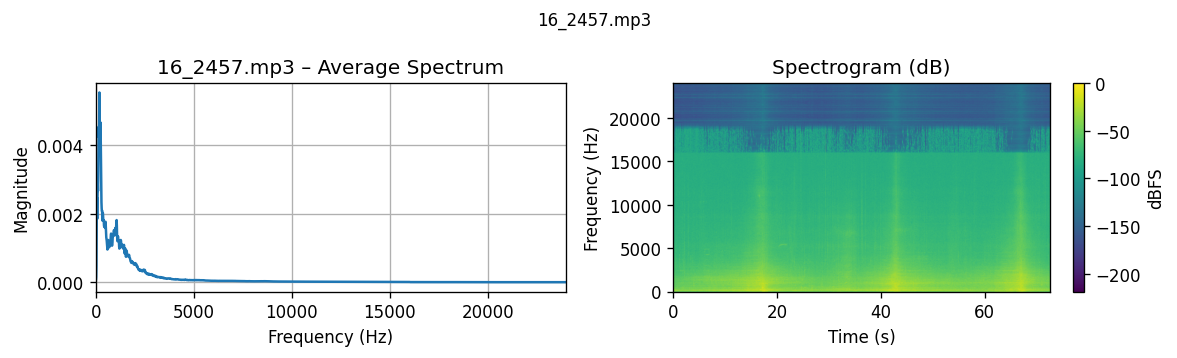

[OK]   16_2519.mp3


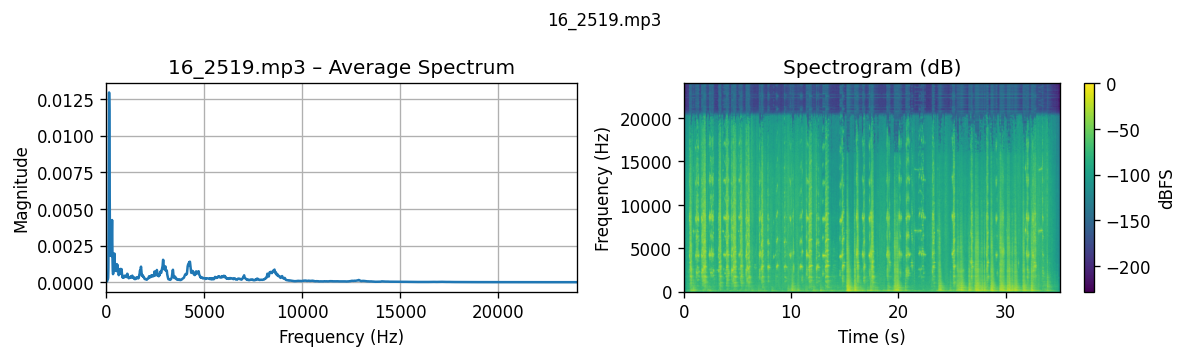

[OK]   16_2554.mp3


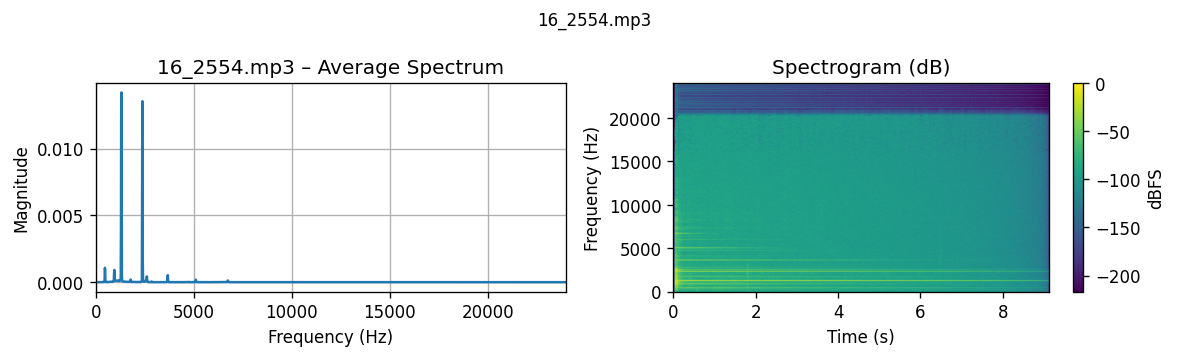

[TONE] 16_2683.mp3  →  ~495.26 Hz


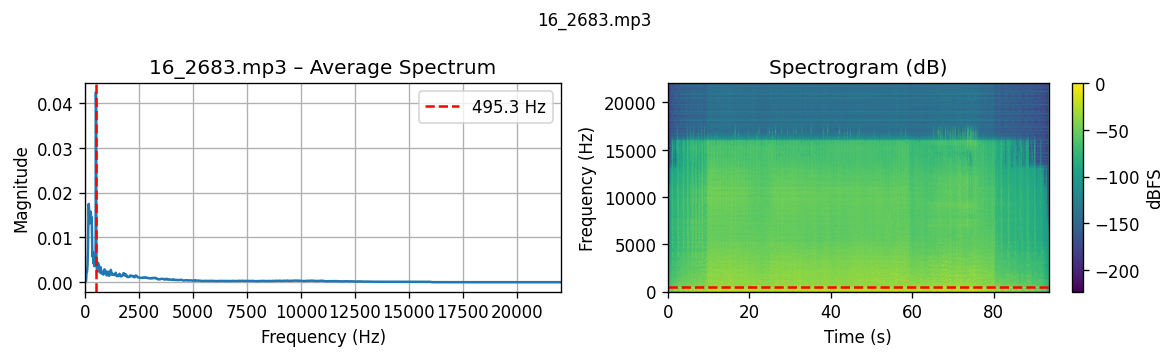

[OK]   16_2810.mp3


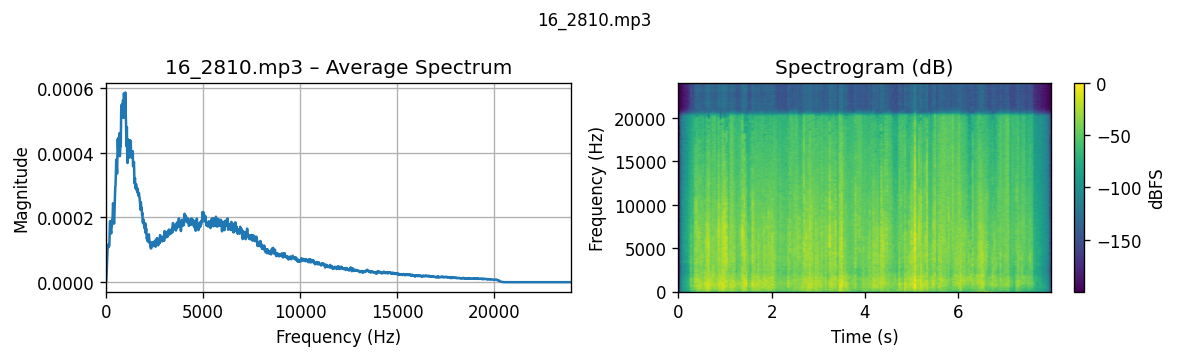

[OK]   16_2835.mp3


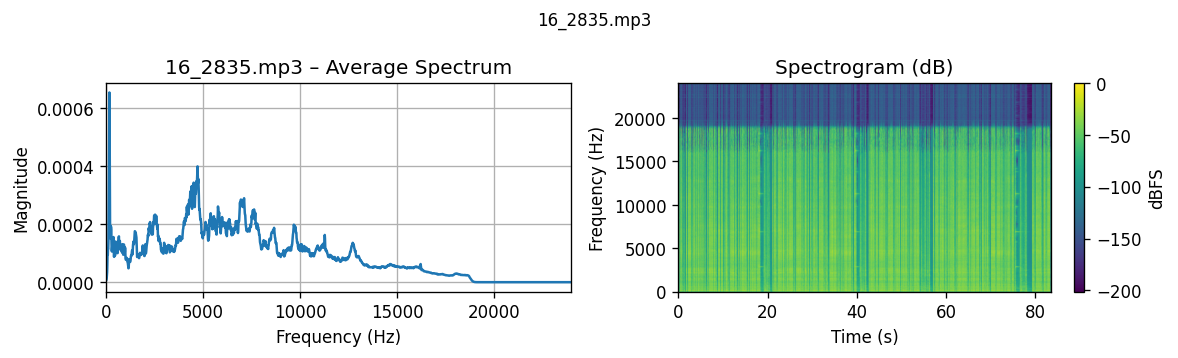

[OK]   16_2847.mp3


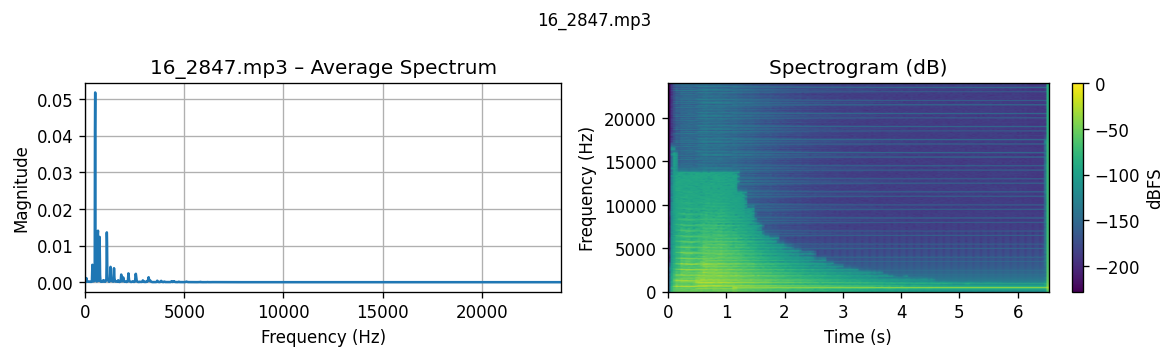

[OK]   16_2852.mp3


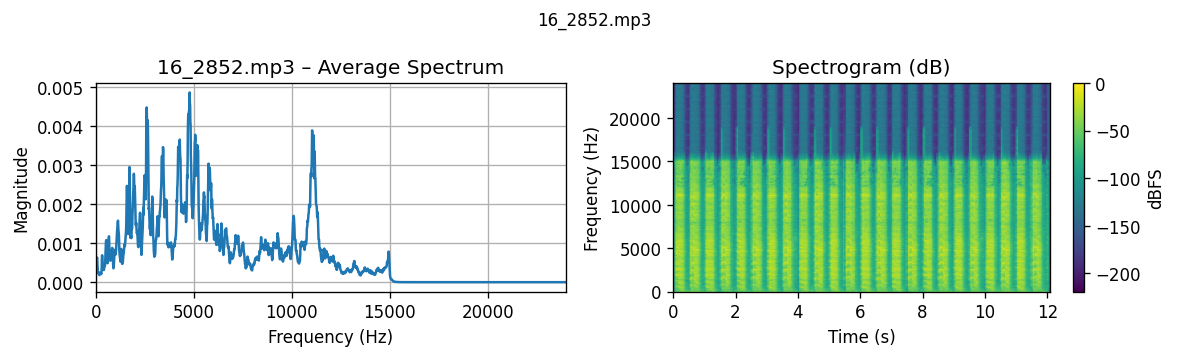

[OK]   16_2947.mp3


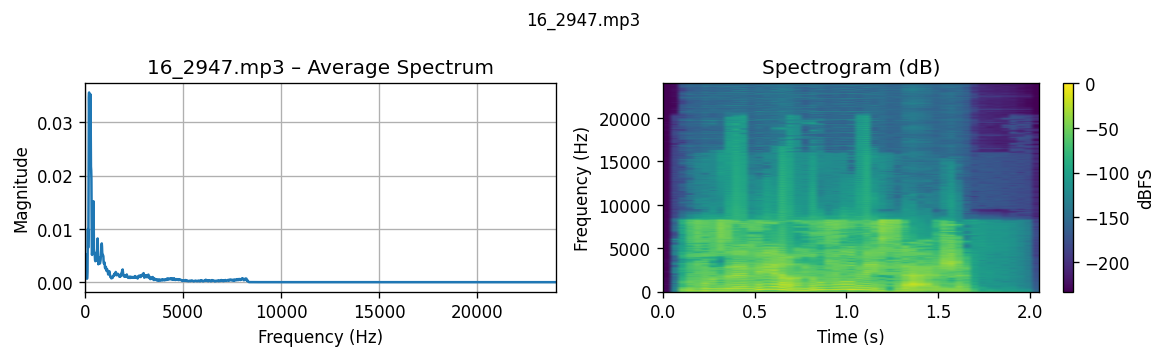


--- Affected files ---
16_2683.mp3  ~495.26 Hz


In [15]:
# Assignment 2c – Detect and visualize files with a constant tone (Jupyter version)

from pathlib import Path
import numpy as np
import soundfile as sf
from scipy.signal import stft
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120

IN_DIR = Path("downloads")
OUT_DIR = Path("tone_plots")
OUT_DIR.mkdir(exist_ok=True)

# ---- parameters ----
NPERSEG = 4096
NOVERLAP = NPERSEG // 2
TONE_PROM_RATIO = 8      # how strong the tone must be vs median
TONE_CV_MAX = 0.30       # how stable the tone must be over time

def load_mono(path):
    data, sr = sf.read(path, always_2d=True)
    x = data.mean(axis=1).astype(np.float32)
    x = x / (np.max(np.abs(x)) + 1e-12)
    return x, sr

def detect_constant_tone(x, sr):
    freqs, times, Z = stft(x, fs=sr, nperseg=NPERSEG, noverlap=NOVERLAP)
    S = np.abs(Z) + 1e-12
    mean_spec = S.mean(axis=1)
    mean_spec[0] = 0  # ignore DC

    pk = np.argmax(mean_spec)
    f_pk = freqs[pk]
    prom_ratio = mean_spec[pk] / (np.median(mean_spec) + 1e-12)
    cv = np.std(S[pk, :]) / (np.mean(S[pk, :]) + 1e-12)

    is_tone = (prom_ratio >= TONE_PROM_RATIO) and (cv <= TONE_CV_MAX)
    return is_tone, f_pk, freqs, S, times

affected = []

for path in sorted(IN_DIR.glob("*.mp3")):
    try:
        x, sr = load_mono(path)
        is_tone, f_tone, freqs, S, times = detect_constant_tone(x, sr)

        if is_tone:
            affected.append((path.name, f_tone))
            print(f"[TONE] {path.name}  →  ~{f_tone:.2f} Hz")
        else:
            print(f"[OK]   {path.name}")

        # ----- visualization -----
        mean_spec = S.mean(axis=1)
        Sdb = 20 * np.log10(S / np.max(S))

        fig, axs = plt.subplots(1, 2, figsize=(10, 3))
        axs[0].plot(freqs, mean_spec)
        if is_tone:
            axs[0].axvline(f_tone, color="r", linestyle="--", label=f"{f_tone:.1f} Hz")
            axs[0].legend()
        axs[0].set_title(f"{path.name} – Average Spectrum")
        axs[0].set_xlabel("Frequency (Hz)")
        axs[0].set_ylabel("Magnitude")
        axs[0].set_xlim(0, sr/2)
        axs[0].grid(True)

        im = axs[1].imshow(
            Sdb,
            origin="lower",
            aspect="auto",
            extent=[times[0], times[-1], freqs[0], freqs[-1]],
            cmap="viridis"
        )
        if is_tone:
            axs[1].axhline(f_tone, color="r", linestyle="--")
        axs[1].set_title("Spectrogram (dB)")
        axs[1].set_xlabel("Time (s)")
        axs[1].set_ylabel("Frequency (Hz)")
        plt.colorbar(im, ax=axs[1], label="dBFS")

        fig.suptitle(path.name, fontsize=10)
        plt.tight_layout()
        plt.show()  # inline output

        # Also save the same figure
        fig.savefig(OUT_DIR / f"{path.stem}_tonecheck.png")
        plt.close(fig)

    except Exception as e:
        print(f"[SKIP] {path.name} ({type(e).__name__}: {e})")

print("\n--- Affected files ---")
if affected:
    for n, f in affected:
        print(f"{n}  ~{f:.2f} Hz")
else:
    print("None detected.")

In [ ]:
-2C procedure explaining-

1. Each .mp3 file is loaded and converted to mono.

2. Compute the Short-Time Fourier Transform (STFT) → gives a time-frequency representation.

3. Take the average spectrum and find the most dominant frequency peak.

4. Check:

    - The peak is much stronger than the background (≥ 8× median).

    - The tone’s intensity doesn’t vary much over time (CV ≤ 0.3).

5. Files meeting both are labeled as affected and visualized inline + saved to tone_plots/.

6. No hard-coded exclusions — unreadable or broken files are simply skipped with a message.

## 2d
(6 points)

You and your team are trying to find out what has caused this tone. An important aspect to this analysis is finding out in which of the files the tone initiates the earliest (in the affected recordings). Again, do this in Python and make sure to clearly visualize. As with all of your answers, make sure to explain why and what you are doing.

[NO TONE] 16_2457.mp3
[NO TONE] 16_2519.mp3
[NO TONE] 16_2554.mp3
[TONE] 16_2683.mp3  f≈495.26 Hz  onset=0.4179591836734694 s


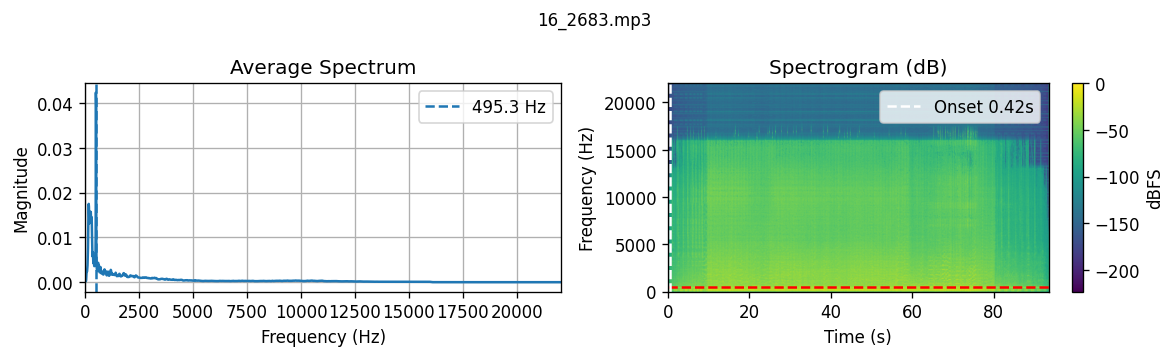

[NO TONE] 16_2810.mp3
[NO TONE] 16_2835.mp3
[NO TONE] 16_2847.mp3
[NO TONE] 16_2852.mp3
[NO TONE] 16_2947.mp3

--- Earliest tone onset (affected files) ---
16_2683.mp3                               onset=0.418 s   f≈495.3 Hz


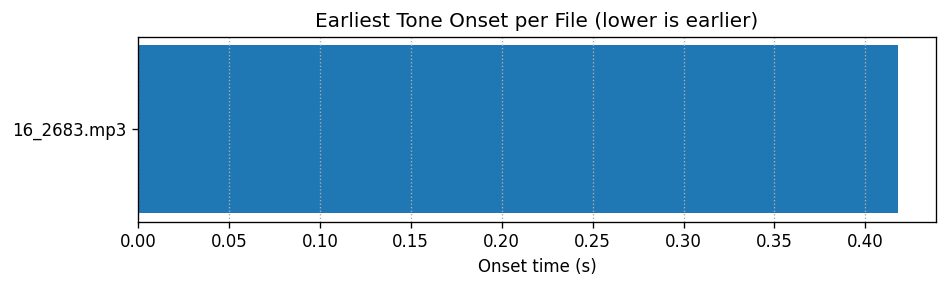

In [16]:
# Assignment 2d – Earliest tone onset detection & visualization

from pathlib import Path
import numpy as np
import soundfile as sf
from scipy.signal import stft
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120

IN_DIR = Path("downloads")
PLOT_DIR = Path("tone_onset_plots"); PLOT_DIR.mkdir(exist_ok=True)

# ---------- STFT / detection parameters (tweak if needed) ----------
NPERSEG = 4096
NOVERLAP = NPERSEG // 2
TONE_PROM_RATIO = 8.0      # how dominant the tone bin must be (vs median spectrum) to count as "a tone file"
ONSET_PROM_RATIO = 4.0     # per-frame: how strong the tone must be vs baseline to count as "on"
ONSET_MIN_FRAMES = 5       # require sustained detection for robustness

def load_mono(path: Path):
    """Read audio, convert to mono float32, normalize peak to 1.0."""
    data, sr = sf.read(path, always_2d=True)
    x = data.mean(axis=1).astype(np.float32)
    x /= (np.max(np.abs(x)) + 1e-12)
    return x, sr

def stft_mag(x: np.ndarray, sr: int):
    """One-sided STFT magnitude, plus time/freq axes."""
    freqs, times, Z = stft(x, fs=sr, nperseg=NPERSEG, noverlap=NOVERLAP, return_onesided=True)
    S = np.abs(Z) + 1e-12
    return freqs, times, S

def detect_tone_bin(freqs: np.ndarray, S: np.ndarray):
    """
    Decide if there's a constant/narrowband tone and return its bin index.
    Uses time-averaged spectrum prominence + low temporal variability.
    """
    mean_spec = S.mean(axis=1).copy()
    if len(mean_spec) < 3:
        return None, None
    mean_spec[0] = 0.0  # ignore DC
    pk = int(np.argmax(mean_spec))
    # prominence vs median
    prom_ratio = mean_spec[pk] / (np.median(mean_spec) + 1e-12)
    # temporal stability at the peak bin
    row = S[pk, :]
    cv = float(np.std(row) / (np.mean(row) + 1e-12))
    is_tone = (prom_ratio >= TONE_PROM_RATIO) and (cv <= 0.30)
    return (pk if is_tone else None), (float(freqs[pk]) if is_tone else None)

def first_sustained_onset(row: np.ndarray, times: np.ndarray):
    """
    Detect earliest time where 'row' (tone-bin magnitude over time) turns on and
    stays on. Baseline is median of the first 0.5 s (or first 10 frames, min).
    Condition: row[t] >= ONSET_PROM_RATIO * baseline for ONSET_MIN_FRAMES in a row.
    Returns onset_time (float seconds) or None.
    """
    if len(row) == 0:
        return None
    # baseline window
    if len(times) < 2:
        return None
    dt = times[1] - times[0]
    k = max(10, int(0.5 / max(dt, 1e-6)))  # ~0.5 s or 10 frames, whichever larger
    k = min(k, len(row))                    # cap to length
    baseline = np.median(row[:k]) + 1e-12

    active = row >= (ONSET_PROM_RATIO * baseline)

    # find first index with ONSET_MIN_FRAMES consecutive Trues
    count = 0
    for i, v in enumerate(active):
        count = count + 1 if v else 0
        if count >= ONSET_MIN_FRAMES:
            onset_idx = i - ONSET_MIN_FRAMES + 1
            return float(times[onset_idx])
    return None

def plot_file(name: str, freqs, times, S, f_tone, onset_time):
    """Inline & file save: spectrogram with tone and onset annotated; plus avg spectrum."""
    mean_spec = S.mean(axis=1)
    Sdb = 20 * np.log10(S / np.max(S))

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    # Average spectrum
    axs[0].plot(freqs, mean_spec)
    if f_tone is not None:
        axs[0].axvline(f_tone, linestyle="--", label=f"{f_tone:.1f} Hz")
        axs[0].legend()
    axs[0].set_title("Average Spectrum")
    axs[0].set_xlabel("Frequency (Hz)")
    axs[0].set_ylabel("Magnitude")
    axs[0].set_xlim(0, freqs[-1])
    axs[0].grid(True)

    # Spectrogram
    im = axs[1].imshow(
        Sdb, origin="lower", aspect="auto",
        extent=[times[0], times[-1], freqs[0], freqs[-1]], cmap="viridis"
    )
    if f_tone is not None:
        axs[1].axhline(f_tone, linestyle="--", color="r")
    if onset_time is not None:
        axs[1].axvline(onset_time, linestyle="--", color="w", label=f"Onset {onset_time:.2f}s")
        axs[1].legend(loc="upper right")
    axs[1].set_title("Spectrogram (dB)")
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Frequency (Hz)")
    plt.colorbar(im, ax=axs[1], label="dBFS")

    fig.suptitle(name, fontsize=10)
    plt.tight_layout()
    plt.show()

    fig.savefig(PLOT_DIR / f"{Path(name).stem}_onset.png")
    plt.close(fig)

# --------- Process all MP3s, detect onset ----------
onsets = []  # list of dicts: {"name": file, "f_tone": Hz, "onset": seconds}

for path in sorted(IN_DIR.glob("*.mp3")):
    try:
        x, sr = load_mono(path)
        freqs, times, S = stft_mag(x, sr)
        pk, f_tone = detect_tone_bin(freqs, S)

        if pk is None:
            print(f"[NO TONE] {path.name}")
            continue

        # onset at the tone bin:
        row = S[pk, :]
        onset_t = first_sustained_onset(row, times)
        onsets.append({"name": path.name, "f_tone": f_tone, "onset": onset_t})

        print(f"[TONE] {path.name}  f≈{f_tone:.2f} Hz  onset={onset_t if onset_t is not None else 'N/A'} s")
        plot_file(path.name, freqs, times, S, f_tone, onset_t)

    except Exception as e:
        print(f"[SKIP] {path.name} ({type(e).__name__}: {e})")

# --------- Summary ranking (earliest onset first) ----------
valid = [r for r in onsets if r["onset"] is not None]
valid_sorted = sorted(valid, key=lambda r: r["onset"])

print("\n--- Earliest tone onset (affected files) ---")
if not valid_sorted:
    print("No affected files with a measurable onset.")
else:
    for r in valid_sorted:
        print(f"{r['name']:<40}  onset={r['onset']:.3f} s   f≈{r['f_tone']:.1f} Hz")

    # Bar chart
    names = [r["name"] for r in valid_sorted]
    times_ = [r["onset"] for r in valid_sorted]

    plt.figure(figsize=(8, max(2.5, 0.35*len(names))))
    y = np.arange(len(names))[::-1]  # earliest at top
    plt.barh(y, times_)
    plt.yticks(y, names)
    plt.xlabel("Onset time (s)")
    plt.title("Earliest Tone Onset per File (lower is earlier)")
    plt.grid(axis="x", linestyle=":")
    plt.tight_layout()
    plt.show()


-2D procedure explaining-

STFT gives time-frequency magnitude S(f,t)

We first confirm the tone frequency by finding the most prominent, stable peak in the time-averaged spectrum.

For that tone bin, we compute a baseline from the first ~0.5 s (or ≥10 frames).

The onset is the first time the tone’s magnitude is ≥ ONSET_PROM_RATIO × baseline for at least ONSET_MIN_FRAMES consecutive frames (robust to flicker).

We visualize per file (spectrogram + onset line) and a summary bar chart ranking earliest onsets.

# Assignment 3

A *friend* used ChatGPT in an attempt to solve a task. Together they got pretty far, but something appears to be off. Here is the code:

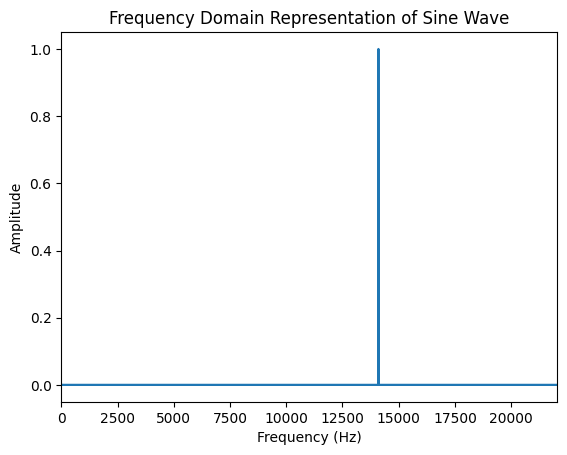

In [1]:
import numpy as np
import matplotlib.pyplot as plt

sample_rate = 44100  # Sample rate in Hz
frequency = 30000   # Frequency of the sine wave in Hz

# Duration of the sine wave in seconds
duration = 1.0

# Generate time values
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Create sine wave values
sine_wave = np.sin(2 * np.pi * frequency * t)

# Perform the FFT
fft_result = np.fft.fft(sine_wave)
fft_freq = np.fft.fftfreq(len(fft_result), 1.0 / sample_rate)

# Plot the magnitude of the FFT
plt.plot(fft_freq, 2/len(fft_freq) * np.abs(fft_result))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Domain Representation of Sine Wave')
plt.xlim(0, sample_rate // 2)  # Display only positive frequencies
plt.show()

## 3a

(2 points)


Your friend thinks something must have gone wrong with the Fast Fourier Transform, as the plotted frequency is clearly lower than the 30000 Hz frequency that was programmed. Do you agree with your friend? Explain why.


No, I do not agree with my friend.
The FFT itself is working correctly. The problem is aliasing caused by undersampling.

--- Explanation ---

The sampling rate in the code is 44,100 Hz,
and the sine wave frequency is 30,000 Hz.

According to the Nyquist–Shannon sampling theorem,
the maximum frequency that can be represented without aliasing is:

fNyquist = fs\2 = 44100\2 = 22050 Hz

Any signal above 22,050 Hz will alias, meaning it appears at a lower frequency in the FFT.

The apparent (aliased) frequency is:

falias=∣fsignal−k⋅fs∣

where k is the integer that brings the result into the 0–Nyquist range.

For a 30 kHz signal:
falias=∣30000−44100∣=14100 Hz

So in the FFT, we see a peak near 14.1 kHz -> 

--> not because the FFT failed but because the sine wave was undersampled.

## 3b
(2 points)

Show how you would solve this. Clearly indicate which lines of codes you altered, using comments. Explain why you altered what you altered.

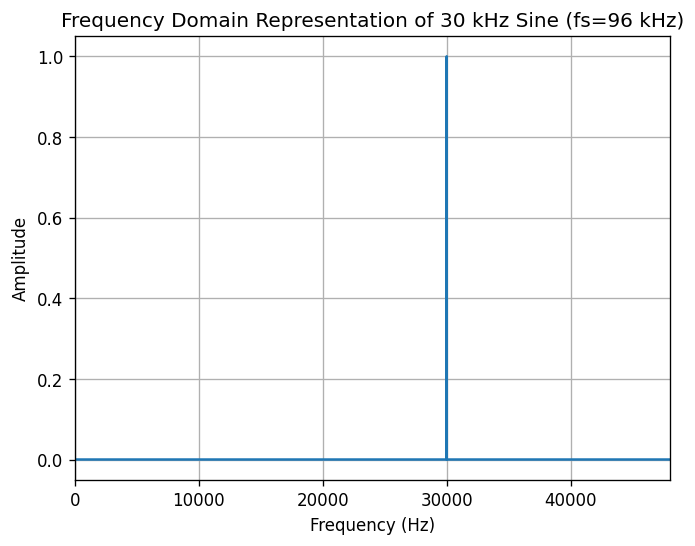

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
sample_rate = 96000        # changed from 44100 -> Nyquist = 48 kHz > 30 kHz, so no aliasing
frequency   = 30000
duration    = 1.0

# --- Time axis ---
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# --- Signal ---
sine_wave = np.sin(2 * np.pi * frequency * t)

# --- FFT (use real-FFT for one-sided spectrum) ---
N = len(sine_wave)
fft_result = np.fft.rfft(sine_wave)               # one-sided FFT for real signals
fft_freq   = np.fft.rfftfreq(N, d=1.0 / sample_rate)

# --- Amplitude scaling for one-sided spectrum ---
amplitude = (2.0 / N) * np.abs(fft_result)

# --- Plot ---
plt.plot(fft_freq, amplitude)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Domain Representation of 30 kHz Sine (fs=96 kHz)')
plt.xlim(0, sample_rate / 2)
plt.grid(True)
plt.show()


In [20]:
# 3B Explaining

# sample_rate = 96000 → ensures Nyquist = 48 kHz > 30 kHz, so no aliasing.

# rfft / rfftfreq → only plots the positive frequencies (real signals don’t need negative side).

# 2/N scaling → adjusts amplitude to show correct magnitude for single-sided FFT.

# (Optional later) Use a Hann window to reduce spectral leakage, or choose duration to make an integer number of cycles.